In [1]:
# Cell 1: Imports and basic configuration

# If any of these are missing, uncomment the pip commands and run once:
# !pip install pandas numpy scikit-learn matplotlib seaborn xgboost

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

# XGBoost classifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

In [2]:
# Cell 2: Load data and basic inspection

# Adjust the path if your CSV is somewhere else
data_path = "BankChurners.csv"  # or "BankChurners.csv" if it's in the same folder as the notebook

df = pd.read_csv(data_path)

print("Shape of raw dataset:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

print("\nInfo:")
print(df.info())

print("\nTarget distribution (Attrition_Flag):")
print(df["Attrition_Flag"].value_counts())
print("\nTarget distribution (normalized):")
print(df["Attrition_Flag"].value_counts(normalize=True))

Shape of raw dataset: (10127, 23)

First 5 rows:


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                                    

In [3]:
# Cell 3: Clean dataset - drop Naive_Bayes and ID column

# Identify Naive_Bayes columns
naive_cols = [c for c in df.columns if c.startswith("Naive_Bayes")]
print("Naive_Bayes-related columns to drop:")
print(naive_cols)

# Drop Naive_Bayes columns and CLIENTNUM (ID, not a feature)
df = df.drop(columns=naive_cols + ["CLIENTNUM"])

print("\nShape after dropping leakage & ID columns:", df.shape)

print("\nFirst 5 rows after cleaning:")
display(df.head())

print("\nColumns and dtypes:")
print(df.dtypes)

Naive_Bayes-related columns to drop:
['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']

Shape after dropping leakage & ID columns: (10127, 20)

First 5 rows after cleaning:


,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000



Columns and dtypes:
Attrition_Flag               object
Customer_Age                  int64
Gender                       object
Dependent_count               int64
Education_Level              object
Marital_Status               object
Income_Category              object
Card_Category                object
Months_on_book                int64
Total_Relationship_Count      int64
Months_Inactive_12_mon        int64
Contacts_Count_12_mon         int64
Credit_Limit                float64
Total_Revolving_Bal           int64
Avg_Open_To_Buy             float64
Total_Amt_Chng_Q4_Q1        float64
Total_Trans_Amt               int64
Total_Trans_Ct                int64
Total_Ct_Chng_Q4_Q1         float64
Avg_Utilization_Ratio       float64
dtype: object


In [4]:
# Cell 4: Basic EDA - missing values and descriptive statistics

print("Missing values per column:")
print(df.isnull().sum())

print("\nTarget distribution (Attrition_Flag):")
print(df["Attrition_Flag"].value_counts())
print("\nTarget distribution (normalized):")
print(df["Attrition_Flag"].value_counts(normalize=True))

print("\nSummary statistics (numeric features):")
display(df.describe().T)

print("\nSummary statistics (including categoricals):")
display(df.describe(include="object").T)

Missing values per column:
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

Target distribution (Attrition_Flag):
Attrition_Flag
Existing Customer    8500
Attrited Customer    1627
Name: count, dtype: int64

Target distribution (normalized):
Attrition_Flag
Existing Customer    0.83934
Attrited Customer    0.16066
Name: proportion, dtype: float64

Summary statistics (numeric features):


,count,mean,std,min,25%,50%,75%,max
Customer_Age,10127.0,46.325960,8.016814,26.0,41.000,46.000,52.000,73.000
Dependent_count,10127.0,2.346203,1.298908,0.0,1.000,2.000,3.000,5.000
Months_on_book,10127.0,35.928409,7.986416,13.0,31.000,36.000,40.000,56.000
Total_Relationship_Count,10127.0,3.812580,1.554408,1.0,3.000,4.000,5.000,6.000
Months_Inactive_12_mon,10127.0,2.341167,1.010622,0.0,2.000,2.000,3.000,6.000
Contacts_Count_12_mon,10127.0,2.455317,1.106225,0.0,2.000,2.000,3.000,6.000
Credit_Limit,10127.0,8631.953698,9088.776650,1438.3,2555.000,4549.000,11067.500,34516.000
Total_Revolving_Bal,10127.0,1162.814061,814.987335,0.0,359.000,1276.000,1784.000,2517.000
Avg_Open_To_Buy,10127.0,7469.139637,9090.685324,3.0,1324.500,3474.000,9859.000,34516.000
Total_Amt_Chng_Q4_Q1,10127.0,0.759941,0.219207,0.0,0.631,0.736,0.859,3.397



Summary statistics (including categoricals):


,count,unique,top,freq
Attrition_Flag,10127,2,Existing Customer,8500
Gender,10127,2,F,5358
Education_Level,10127,7,Graduate,3128
Marital_Status,10127,4,Married,4687
Income_Category,10127,6,Less than $40K,3561
Card_Category,10127,4,Blue,9436


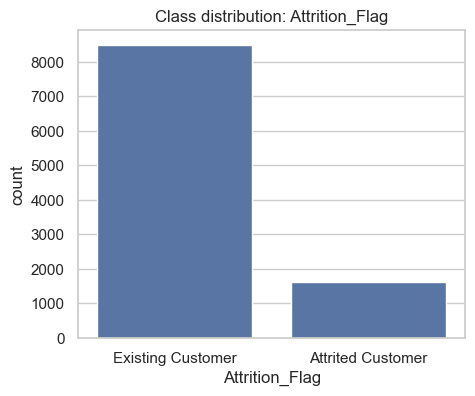

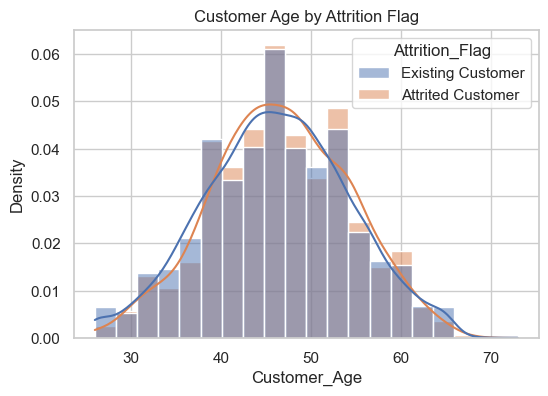

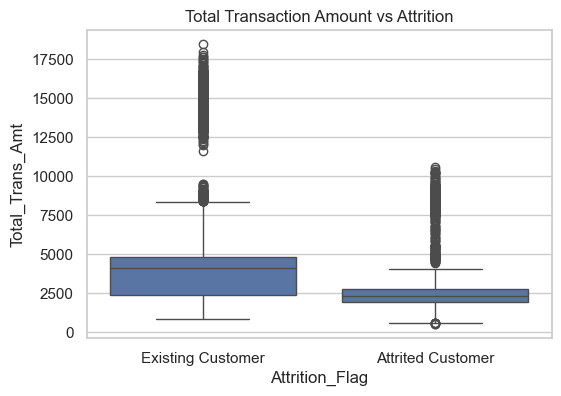

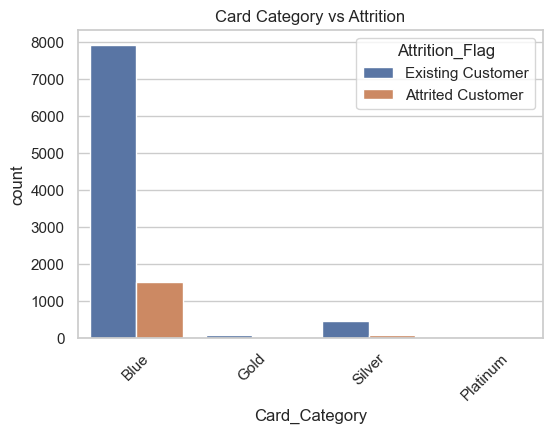

In [5]:
# Cell 5: A few quick plots for EDA

# 1) Class balance
plt.figure(figsize=(5,4))
sns.countplot(x="Attrition_Flag", data=df)
plt.title("Class distribution: Attrition_Flag")
plt.show()

# 2) Age distribution by attrition
plt.figure(figsize=(6,4))
sns.histplot(data=df, x="Customer_Age", hue="Attrition_Flag", bins=20, kde=True, stat="density", common_norm=False)
plt.title("Customer Age by Attrition Flag")
plt.show()

# 3) Total_Trans_Amt by attrition
plt.figure(figsize=(6,4))
sns.boxplot(x="Attrition_Flag", y="Total_Trans_Amt", data=df)
plt.title("Total Transaction Amount vs Attrition")
plt.show()

# 4) Categorical example: Card_Category vs attrition
plt.figure(figsize=(6,4))
sns.countplot(x="Card_Category", hue="Attrition_Flag", data=df)
plt.title("Card Category vs Attrition")
plt.xticks(rotation=45)
plt.show()

In [6]:
# Cell 6: Define target y and feature matrix X

# Binary encode target: 1 for Attrited, 0 for Existing
df["Attrition_Flag_Binary"] = (df["Attrition_Flag"] == "Attrited Customer").astype(int)

y = df["Attrition_Flag_Binary"]
X = df.drop(columns=["Attrition_Flag", "Attrition_Flag_Binary"])

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Numeric features:", numeric_features)
print("\nCategorical features:", categorical_features)

Numeric features: ['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']

Categorical features: ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']


In [7]:
# Cell 7: Train/test split (stratified)

# y and X were defined in Cell 6
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train mean (churn rate):", y_train.mean())
print("y_test mean (churn rate): ", y_test.mean())

X_train shape: (8101, 19)
X_test shape:  (2026, 19)
y_train mean (churn rate): 0.1607208986544871
y_test mean (churn rate):  0.16041461006910168


In [8]:
# Cell 8: Preprocessing - ColumnTransformer with scaling + one-hot encoding

numeric_features = ['Customer_Age', 'Dependent_count', 'Months_on_book',
                    'Total_Relationship_Count', 'Months_Inactive_12_mon',
                    'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
                    'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
                    'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']

categorical_features = ['Gender', 'Education_Level', 'Marital_Status',
                        'Income_Category', 'Card_Category']

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

print(preprocessor)

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['Customer_Age', 'Dependent_count',
                                  'Months_on_book', 'Total_Relationship_Count',
                                  'Months_Inactive_12_mon',
                                  'Contacts_Count_12_mon', 'Credit_Limit',
                                  'Total_Revolving_Bal', 'Avg_Open_To_Buy',
                                  'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
                                  'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1',
                                  'Avg_Utilization_Ratio']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['Gender', 'Education_Level', 'Marital_Status',
                                  'Income_Category', 'Card_Category'])])


In [9]:
# Cell 9: Train 5 models with cross-validation and compare

from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Define models
models = {
    "LogisticRegression": LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        solver="lbfgs"
    ),
    "DecisionTree": DecisionTreeClassifier(
        max_depth=5,
        random_state=42,
        class_weight="balanced"
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    ),
    "GradientBoosting": GradientBoostingClassifier(
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    )
}

# CV setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "roc_auc": "roc_auc",
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1"
}

results = []

for name, model in models.items():
    print(f"Running CV for: {name}")
    
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    
    cv_results = cross_validate(
        pipe,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False
    )
    
    results.append({
        "model": name,
        "roc_auc_mean":  cv_results["test_roc_auc"].mean(),
        "roc_auc_std":   cv_results["test_roc_auc"].std(),
        "accuracy_mean": cv_results["test_accuracy"].mean(),
        "precision_mean": cv_results["test_precision"].mean(),
        "recall_mean":    cv_results["test_recall"].mean(),
        "f1_mean":        cv_results["test_f1"].mean()
    })

results_df = pd.DataFrame(results).sort_values(by="roc_auc_mean", ascending=False)
display(results_df)

Running CV for: LogisticRegression
Running CV for: DecisionTree
Running CV for: RandomForest
Running CV for: GradientBoosting
Running CV for: XGBoost


,model,roc_auc_mean,roc_auc_std,accuracy_mean,precision_mean,recall_mean,f1_mean
4,XGBoost,0.993272,0.001763,0.971978,0.937507,0.884807,0.910318
3,GradientBoosting,0.989464,0.002229,0.963955,0.931259,0.837961,0.881890
2,RandomForest,0.988113,0.002988,0.948648,0.923574,0.741948,0.822784
1,DecisionTree,0.951499,0.007103,0.895814,0.621794,0.909378,0.737878
0,LogisticRegression,0.925439,0.007474,0.849030,0.518918,0.847179,0.643440


In [10]:
# Cell 10: Train the best model (XGBoost) on full training data

best_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

best_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", best_model)
])

best_pipeline.fit(X_train, y_train)

print("Training complete.")

Training complete.


TRAIN SET PERFORMANCE
---------------------
ROC-AUC: 0.9988994947978479

Classification report (train):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6799
           1       0.97      0.96      0.97      1302

    accuracy                           0.99      8101
   macro avg       0.98      0.98      0.98      8101
weighted avg       0.99      0.99      0.99      8101



TEST SET PERFORMANCE
--------------------
ROC-AUC: 0.9926685660018995

Classification report (test):
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1701
           1       0.96      0.86      0.91       325

    accuracy                           0.97      2026
   macro avg       0.97      0.93      0.94      2026
weighted avg       0.97      0.97      0.97      2026



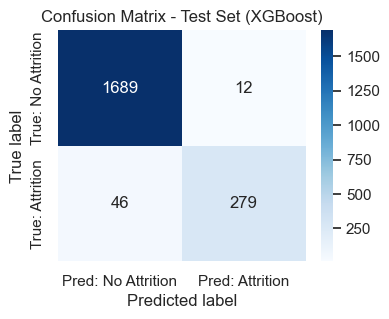

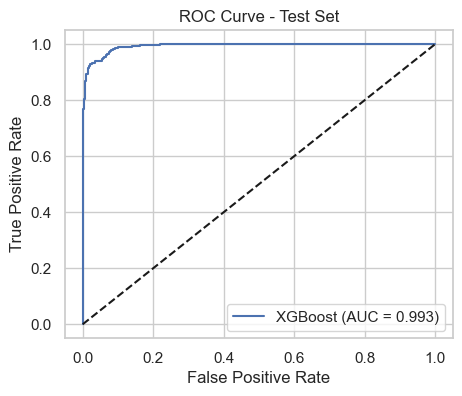

In [11]:
# Cell 11: Evaluate the trained XGBoost pipeline

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# --- Train performance ---
y_train_pred = best_pipeline.predict(X_train)
y_train_proba = best_pipeline.predict_proba(X_train)[:, 1]

print("TRAIN SET PERFORMANCE")
print("---------------------")
print("ROC-AUC:", roc_auc_score(y_train, y_train_proba))
print("\nClassification report (train):")
print(classification_report(y_train, y_train_pred))

# --- Test performance ---
y_test_pred = best_pipeline.predict(X_test)
y_test_proba = best_pipeline.predict_proba(X_test)[:, 1]

print("\n\nTEST SET PERFORMANCE")
print("--------------------")
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba))
print("\nClassification report (test):")
print(classification_report(y_test, y_test_pred))

# Confusion matrix (test)
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred: No Attrition", "Pred: Attrition"],
            yticklabels=["True: No Attrition", "True: Attrition"])
plt.title("Confusion Matrix - Test Set (XGBoost)")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

# ROC curve (test)
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {roc_auc_score(y_test, y_test_proba):.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Test Set")
plt.legend(loc="lower right")
plt.show()

In [12]:
# Cell 12 (fixed): Build and fit a calibrated XGBoost pipeline

from sklearn.calibration import CalibratedClassifierCV

# Base XGBoost with same params as before
xgb_base = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

# Calibrated classifier (isotonic calibration)
calibrated_clf = CalibratedClassifierCV(
    estimator=xgb_base,   # <-- changed from base_estimator= to estimator=
    method="isotonic",    # or "sigmoid" if you want faster but slightly less flexible
    cv=3
)

calibrated_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("calibrated_model", calibrated_clf)
])

print("Fitting calibrated XGBoost pipeline...")
calibrated_pipeline.fit(X_train, y_train)
print("Done.")

Fitting calibrated XGBoost pipeline...
Done.


Brier score (lower is better):
  Uncalibrated XGBoost: 0.0227
  Calibrated XGBoost:   0.0227

ROC-AUC with calibrated model:
  ROC-AUC (calibrated): 0.9922

Classification report (calibrated, threshold=0.5):
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1701
           1       0.95      0.87      0.91       325

    accuracy                           0.97      2026
   macro avg       0.96      0.93      0.95      2026
weighted avg       0.97      0.97      0.97      2026



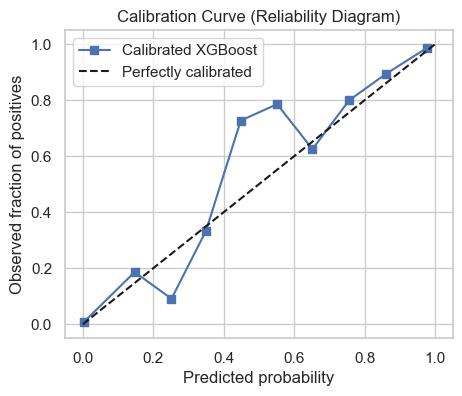

In [13]:
# Cell 13: Evaluate calibration of probabilities on the test set

from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve

# Uncalibrated probabilities from earlier best_pipeline
y_test_proba_uncal = best_pipeline.predict_proba(X_test)[:, 1]
brier_uncal = brier_score_loss(y_test, y_test_proba_uncal)

# Calibrated probabilities
y_test_proba_cal = calibrated_pipeline.predict_proba(X_test)[:, 1]
brier_cal = brier_score_loss(y_test, y_test_proba_cal)

print("Brier score (lower is better):")
print(f"  Uncalibrated XGBoost: {brier_uncal:.4f}")
print(f"  Calibrated XGBoost:   {brier_cal:.4f}")

print("\nROC-AUC with calibrated model:")
print("  ROC-AUC (calibrated): {:.4f}".format(roc_auc_score(y_test, y_test_proba_cal)))

# Classification report at default 0.5 threshold (for reference)
y_test_pred_cal_05 = (y_test_proba_cal >= 0.5).astype(int)
print("\nClassification report (calibrated, threshold=0.5):")
print(classification_report(y_test, y_test_pred_cal_05))

# Plot reliability curve
prob_true, prob_pred = calibration_curve(y_test, y_test_proba_cal, n_bins=10, strategy='uniform')

plt.figure(figsize=(5,4))
plt.plot(prob_pred, prob_true, "s-", label="Calibrated XGBoost")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.xlabel("Predicted probability")
plt.ylabel("Observed fraction of positives")
plt.title("Calibration Curve (Reliability Diagram)")
plt.legend()
plt.show()

In [14]:
# Cell 14: Business profit function

from sklearn.metrics import confusion_matrix

# You can tune these based on domain knowledge
CUSTOMER_LTV = 1000.0          # money lost if a customer leaves
COST_RETENTION_OFFER = 100.0   # cost of giving a retention offer

def compute_profit(y_true, y_proba, threshold,
                   customer_ltv=CUSTOMER_LTV,
                   offer_cost=COST_RETENTION_OFFER):
    """
    Given true labels and predicted probabilities, compute profit at a given threshold.
    y_true: 0 = existing customer (no attrition), 1 = attrited
    y_proba: probability of attrition (class 1)
    threshold: probability cutoff at which we decide to give an offer
    """
    y_pred = (y_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Business logic:
    # - TP: correctly predicted attriters; we give offer and they stay
    #       profit = LTV - offer_cost
    # - FP: predicted attriters but they would have stayed anyway
    #       we waste the offer => -offer_cost
    # - FN: we miss real attriters; they leave => -LTV
    # - TN: correctly predicted non-attriters; do nothing => 0
    total_profit = (tp * (customer_ltv - offer_cost)) \
                   - (fp * offer_cost) \
                   - (fn * customer_ltv)
    
    return {
        "threshold": threshold,
        "tp": tp,
        "fp": fp,
        "fn": fn,
        "tn": tn,
        "total_profit": total_profit
    }

Best threshold for profit: 0.040
Max profit on TEST set:   271200.00

Details at best threshold:


threshold            0.04
tp                 321.00
fp                 137.00
fn                   4.00
tn                1564.00
total_profit    271200.00
Name: 3, dtype: float64

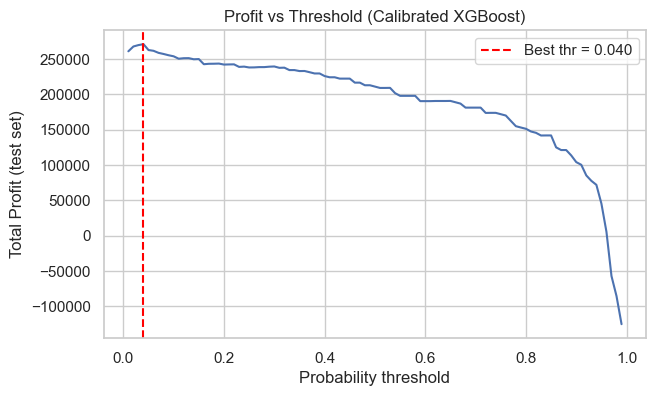

In [15]:
# Cell 15: Profit curve and optimal threshold

# Get calibrated probabilities on test set
y_test_proba_cal = calibrated_pipeline.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0.01, 0.99, 99)  # from 0.01 to 0.99
profit_results = []

for thr in thresholds:
    res = compute_profit(y_test, y_test_proba_cal, thr)
    profit_results.append(res)

profit_df = pd.DataFrame(profit_results)

# Find threshold with maximum profit
best_row = profit_df.loc[profit_df["total_profit"].idxmax()]
best_threshold = best_row["threshold"]
best_profit = best_row["total_profit"]

print("Best threshold for profit: {:.3f}".format(best_threshold))
print("Max profit on TEST set:   {:.2f}".format(best_profit))
print("\nDetails at best threshold:")
display(best_row)

# Plot profit vs threshold
plt.figure(figsize=(7,4))
plt.plot(profit_df["threshold"], profit_df["total_profit"])
plt.axvline(best_threshold, color="red", linestyle="--",
            label=f"Best thr = {best_threshold:.3f}")
plt.xlabel("Probability threshold")
plt.ylabel("Total Profit (test set)")
plt.title("Profit vs Threshold (Calibrated XGBoost)")
plt.legend()
plt.show()

Best threshold for profit: 0.040
Precision: 0.701
Recall:    0.988
F1-score:  0.820


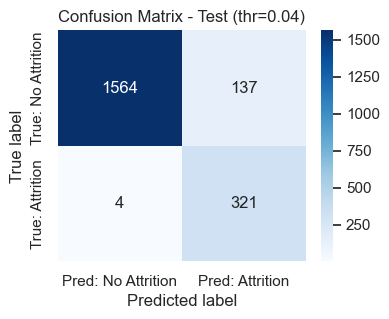

In [16]:
# Cell 16: Evaluate model at best (profit-based) threshold

from sklearn.metrics import precision_score, recall_score, f1_score

# Predictions at best threshold
y_test_pred_best = (y_test_proba_cal >= best_threshold).astype(int)

precision_best = precision_score(y_test, y_test_pred_best)
recall_best = recall_score(y_test, y_test_pred_best)
f1_best = f1_score(y_test, y_test_pred_best)

print(f"Best threshold for profit: {best_threshold:.3f}")
print(f"Precision: {precision_best:.3f}")
print(f"Recall:    {recall_best:.3f}")
print(f"F1-score:  {f1_best:.3f}")

cm_best = confusion_matrix(y_test, y_test_pred_best)
plt.figure(figsize=(4,3))
sns.heatmap(cm_best, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred: No Attrition", "Pred: Attrition"],
            yticklabels=["True: No Attrition", "True: Attrition"])
plt.title(f"Confusion Matrix - Test (thr={best_threshold:.2f})")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

In [17]:
# Cell 17: Save calibrated pipeline and best threshold to disk

import joblib
import os

output_dir = "models"
os.makedirs(output_dir, exist_ok=True)

model_path = os.path.join(output_dir, "credit_card_churn_xgb_calibrated.pkl")

to_save = {
    "model": calibrated_pipeline,
    "best_threshold": best_threshold,
    "customer_ltv": CUSTOMER_LTV,
    "offer_cost": COST_RETENTION_OFFER
}

joblib.dump(to_save, model_path)
print(f"Saved calibrated model and config to: {model_path}")

Saved calibrated model and config to: models\credit_card_churn_xgb_calibrated.pkl


In [18]:
import sys, subprocess

try:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--user", "shap"])
    print("shap installed successfully. Please restart the kernel and then import shap.")
except Exception as e:
    print("Error while installing shap:", e)

shap installed successfully. Please restart the kernel and then import shap.


In [19]:
# Cell 18: Install & set up SHAP

# If shap is not installed, uncomment and run once:
# !pip install shap

import shap

# Initialize JS for nicer plots (even if we use matplotlib-based)
shap.initjs()

# Get the fitted preprocessor and model from best_pipeline
pre = best_pipeline.named_steps["preprocessor"]
xgb_model = best_pipeline.named_steps["model"]

# Transform a sample of the training data for SHAP (to speed things up)
np.random.seed(42)
sample_size = 1000 if len(X_train) > 1000 else len(X_train)
sample_idx = np.random.choice(len(X_train), size=sample_size, replace=False)

X_train_sample = X_train.iloc[sample_idx]
y_train_sample = y_train.iloc[sample_idx]

X_train_sample_trans = pre.transform(X_train_sample)
feature_names = pre.get_feature_names_out()

X_train_sample_trans.shape, len(feature_names)

((1000, 37), 37)

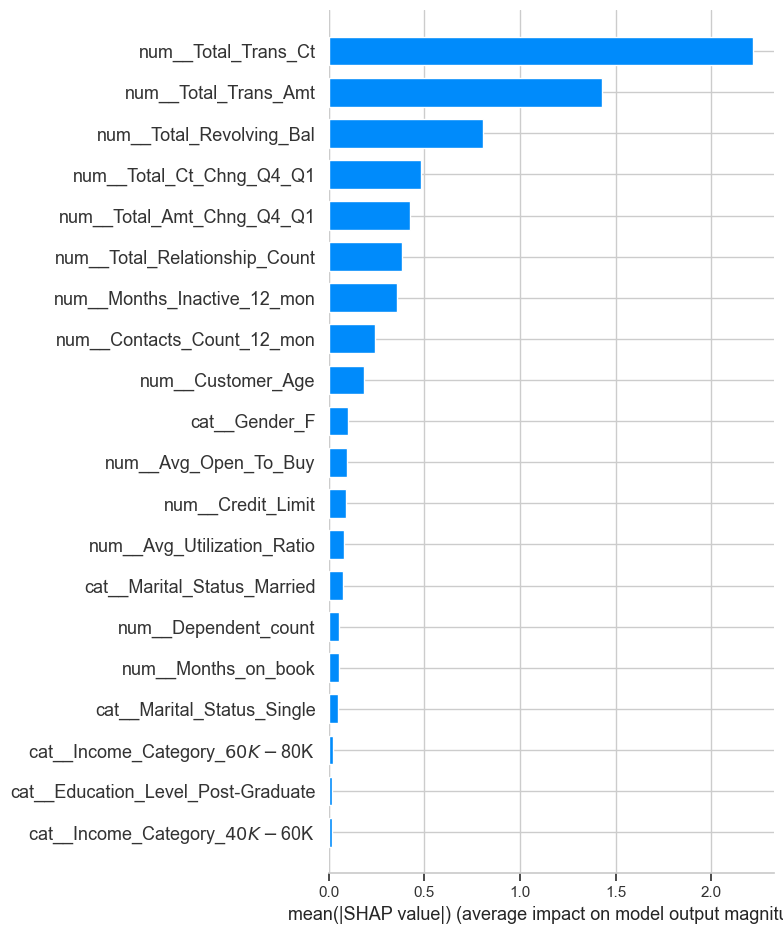

In [20]:
# Cell 19: Global feature importance with SHAP

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train_sample_trans)

# Summary plot (bar) - which features matter most overall
shap.summary_plot(
    shap_values,
    X_train_sample_trans,
    feature_names=feature_names,
    plot_type="bar",
    max_display=20
)

True label (1 = attrited, 0 = existing): 0
Predicted probability of attrition: 0.002


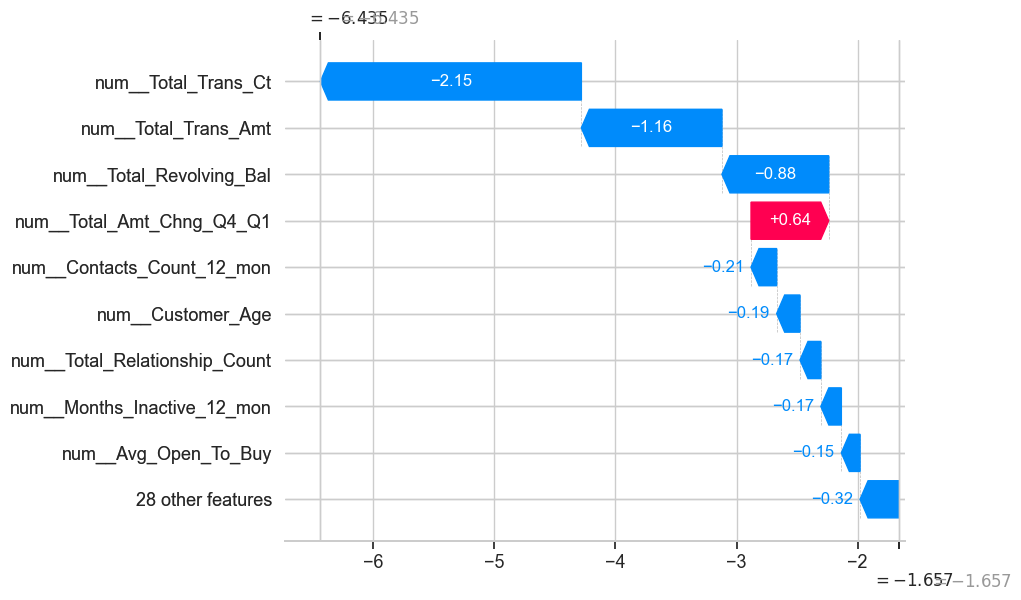

In [21]:
# Cell 20: Local explanation for a single test customer

# Choose an index from the test set
idx = 0  # you can change this to inspect different customers

x_test_row = X_test.iloc[[idx]]
y_test_true = y_test.iloc[idx]

# Transform and predict
x_test_row_trans = pre.transform(x_test_row)
y_test_proba_row = xgb_model.predict_proba(x_test_row_trans)[0, 1]

print("True label (1 = attrited, 0 = existing):", y_test_true)
print("Predicted probability of attrition:", round(y_test_proba_row, 3))

shap_values_row = explainer.shap_values(x_test_row_trans)[0]

# Waterfall-style plot (matplotlib) for this one row
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_values_row,
    feature_names=feature_names
)

In [22]:
# Cell 21: Save calibrated pipeline and best threshold

import joblib
import os

# Folder to store models (will be created if not present)
output_dir = "models"
os.makedirs(output_dir, exist_ok=True)

model_path = os.path.join(output_dir, "credit_card_churn_xgb_calibrated.pkl")

to_save = {
    "model": calibrated_pipeline,     # calibrated XGBoost pipeline
    "best_threshold": best_threshold, # profit-optimal threshold from earlier
    "customer_ltv": CUSTOMER_LTV,
    "offer_cost": COST_RETENTION_OFFER,
    "feature_columns": list(X.columns),
}

joblib.dump(to_save, model_path)
print(f"Saved calibrated model and config to: {model_path}")

Saved calibrated model and config to: models\credit_card_churn_xgb_calibrated.pkl
